In [5]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, LayerNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1_l2, l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

# 1. Preprocessing

### Data Gathering

In [6]:
indexes = []
all_indexes = {}

In [ ]:
all_indexes = pd.read_excel('../Data/Index_Data.xlsx', sheet_name=None)

for sheet_name, df in all_indexes.items():
    indexes.append(sheet_name)
    all_indexes[sheet_name] = df

In [8]:
BSESN = all_indexes['BSESN']
BSESN.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock_Splits,Percent_Change_In_Price,Momentum_Indicator,High_Low_Change,High_Open_Change,Low_Open_Change,Day,Month,Year
6803,2025-02-11 00:00:00+05:30,77384.976562,77387.281250,76030.593750,76293.601562,9800,0,0,-0.013170,-0.014103,0.017844,0.000030,-0.017502,11,2,2025
6804,2025-02-12 00:00:00+05:30,76188.242188,76459.718750,75388.390625,76171.078125,10400,0,0,-0.001606,-0.000225,0.014211,0.003563,-0.010498,12,2,2025
6805,2025-02-13 00:00:00+05:30,76201.101562,76764.531250,76013.429688,76138.968750,6900,0,0,-0.000422,-0.000815,0.009881,0.007394,-0.002463,13,2,2025
6806,2025-02-14 00:00:00+05:30,76388.992188,76483.062500,75439.640625,75939.210938,9300,0,0,-0.002624,-0.005888,0.013831,0.001231,-0.012428,14,2,2025
6807,2025-02-17 00:00:00+05:30,75641.406250,76041.960938,75294.757812,75996.859375,0,0,0,0.000759,0.004699,0.009924,0.005295,-0.004583,17,2,2025


In [9]:
BSESN.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock_Splits,Percent_Change_In_Price,Momentum_Indicator,High_Low_Change,High_Open_Change,Low_Open_Change,Day,Month,Year
0,1997-07-01 00:00:00+05:30,4263.109863,4301.770020,4247.660156,4300.859863,0,0,0,NaN,0.008855,0.012739,0.009069,-0.003624,1,7,1997
1,1997-07-02 00:00:00+05:30,4302.959961,4395.310059,4295.399902,4333.899902,0,0,0,0.007682,0.007190,0.023260,0.021462,-0.001757,2,7,1997
2,1997-07-03 00:00:00+05:30,4335.790039,4393.290039,4299.970215,4323.459961,0,0,0,-0.002409,-0.002844,0.021702,0.013262,-0.008261,3,7,1997
3,1997-07-04 00:00:00+05:30,4332.700195,4347.589844,4300.580078,4323.819824,0,0,0,0.000083,-0.002050,0.010931,0.003437,-0.007413,4,7,1997
4,1997-07-07 00:00:00+05:30,4326.810059,4391.009766,4289.490234,4291.450195,0,0,0,-0.007486,-0.008172,0.023667,0.014838,-0.008625,7,7,1997


In [10]:
len(BSESN)

6808

### Feature Engineering

In [11]:
BSESN['Date'] = pd.to_datetime(BSESN['Date'])
BSESN = BSESN.sort_values('Date').reset_index(drop=True)

In [12]:
BSESN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6808 entries, 0 to 6807
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype                    
---  ------                   --------------  -----                    
 0   Date                     6808 non-null   datetime64[ns, UTC+05:30]
 1   Open                     6808 non-null   float64                  
 2   High                     6808 non-null   float64                  
 3   Low                      6808 non-null   float64                  
 4   Close                    6808 non-null   float64                  
 5   Volume                   6808 non-null   int64                    
 6   Dividends                6808 non-null   int64                    
 7   Stock_Splits             6808 non-null   int64                    
 8   Percent_Change_In_Price  6807 non-null   float64                  
 9   Momentum_Indicator       6808 non-null   float64                  
 10  High_Low_Change         

In [13]:
def create_feature(df, final_df):
    final_df['RSI'] = 100 - (100 / (1 + (df['Close'].diff().clip(lower=0).rolling(window=14).mean() / df['Close'].diff().clip(upper=0).abs().rolling(window=14).mean())))
    final_df['Daily_Range'] = df['High'] - df['Low']
    final_df['Close_Low_Ratio'] = (df['Close'] - df['Low']) / df['Low']
    final_df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
    final_df['ATR'] = final_df['Daily_Range'].rolling(window=14).mean()
    final_df['Rolling_Std_Dev'] = df['Close'].rolling(window=14).std()

    return final_df

In [14]:
new_df = pd.DataFrame()

new_df['Day'] = BSESN['Day']
new_df['Month'] = BSESN['Month']
new_df['Year'] = BSESN['Year']
new_df['Close'] = BSESN['Close']

new_df = create_feature(BSESN, new_df)
new_df.tail()

,Day,Month,Year,Close,RSI,Daily_Range,Close_Low_Ratio,MACD,ATR,Rolling_Std_Dev
6803,11,2,2025,76293.601562,49.247880,1356.687500,0.003459,-163.978442,779.252232,956.567186
6804,12,2,2025,76171.078125,47.643731,1071.328125,0.010382,-237.491591,817.102679,975.092398
6805,13,2,2025,76138.968750,49.638114,751.101562,0.001652,-294.942337,806.881138,978.468637
6806,14,2,2025,75939.210938,54.414854,1043.421875,0.006622,-352.527535,834.402344,914.995991
6807,17,2,2025,75996.859375,50.793814,747.203125,0.009325,-389.028000,824.196987,906.201408


In [15]:
new_df.isna().sum()

,0
Day,0
Month,0
Year,0
Close,0
RSI,14
Daily_Range,0
Close_Low_Ratio,0
MACD,0
ATR,13
Rolling_Std_Dev,13


In [16]:
new_df.dropna(inplace=True)

In [17]:
new_df.isna().sum()

,0
Day,0
Month,0
Year,0
Close,0
RSI,0
Daily_Range,0
Close_Low_Ratio,0
MACD,0
ATR,0
Rolling_Std_Dev,0


In [18]:
X_data = new_df.drop('Close', axis=1).values
y_data = new_df['Close'].values.reshape(-1, 1)

### Data Normalization

In [19]:
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()
# scaler_features = StandardScaler()
# scaler_target = StandardScaler()
scaled_X_data = scaler_features.fit_transform(X_data)
scaled_y_data = scaler_target.fit_transform(y_data)

# scaled_X_data = X_data
# scaled_y_data = y_data

### Create Sequences

In [20]:
# Create sequences for LSTM
def create_sequences(features, target, seq_length=90):
    X, y = [], []
    for i in range(seq_length, len(features)):
        X.append(features[i-seq_length:i, :])
        y.append(target[i, 0])
    return np.array(X), np.array(y)

In [21]:
X, y = create_sequences(scaled_X_data, scaled_y_data)

### Data splitting

In [22]:
training_size = int(len(X) * 0.7)
validation_size = int(len(X) * 0.9)

X_train, X_validate, X_test = X[:training_size], X[training_size:validation_size], X[validation_size:]
y_train, y_validate, y_test = y[:training_size], y[training_size:validation_size], y[validation_size:]

print(len(X))
print(f"{len(X_train)}")
print(f"{len(X_validate)}")
print(f"{len(X_test)}")
print(f"{len(y_test)}")

6704
4692
1341
671
671


In [23]:
print(f"X_train: {X_train.shape}")
print(f"X_validate: {X_validate.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_validate: {y_validate.shape}")
print(f"y_test: {y_test.shape}")

X_train: (4692, 90, 9)
X_validate: (1341, 90, 9)
X_test: (671, 90, 9)
y_train: (4692,)
y_validate: (1341,)
y_test: (671,)


# 2. Model creation

### Plot epoch vs loss & epoch vs mae

In [24]:
def plot_loss_mae(history):
    # Extract values from history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    mae = history.history['mean_absolute_error']
    val_mae = history.history['val_mean_absolute_error']

    epochs = range(1, len(loss) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r^-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(epochs, mae, 'bo-', label='Training MAE')
    plt.plot(epochs, val_mae, 'r^-', label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.title('Training vs Validation MAE')
    plt.legend()

    plt.show()

### LSTM model

Epoch 1/50
294/294 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 2.0413 - mean_absolute_error: 1.0329 - val_loss: 0.2324 - val_mean_absolute_error: 0.4211 - learning_rate: 3.0000e-05
Epoch 2/50
294/294 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 1.7770 - mean_absolute_error: 0.9796 - val_loss: 0.1348 - val_mean_absolute_error: 0.2811 - learning_rate: 3.0000e-05
Epoch 3/50
294/294 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.5894 - mean_absolute_error: 0.9115 - val_loss: 0.0967 - val_mean_absolute_error: 0.2339 - learning_rate: 3.0000e-05
Epoch 4/50
294/294 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.4538 - mean_absolute_error: 0.8655 - val_loss: 0.1058 - val_mean_absolute_error: 0.2471 - learning_rate: 3.0000e-05
Epoch 5/50
294/294 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 1.3523 - mean_absolute_error: 0.8436 - val_loss: 0.0956 - val_mean_absolute_error: 0.2373 - learning_rate: 3.0000e-05
Epoch 6/50
294/294 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.1173 - mean_absolute_error: 0.7649 - val_l

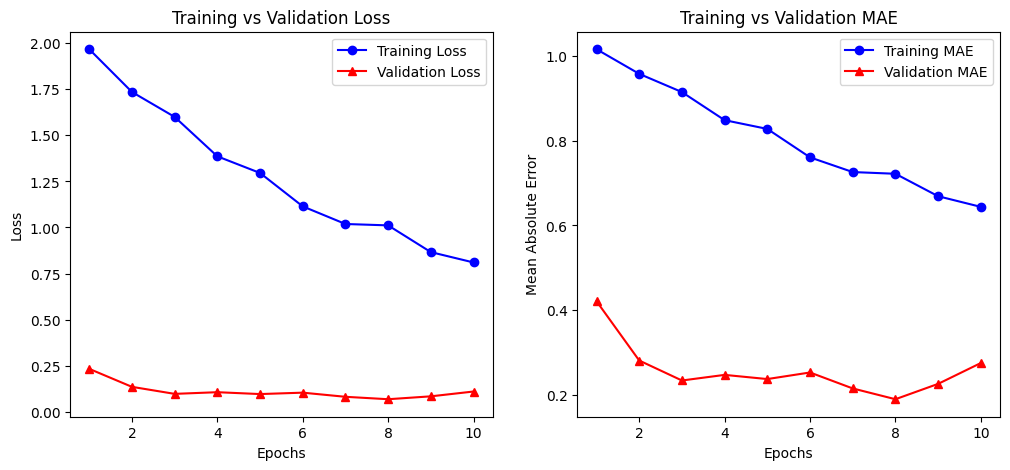

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Mean Absolute Error on test data: 0.3044179347461711
Mean Absolute Error on Inversed test data: 25338.531442110656


In [55]:
# K.clear_session()

# # LSTM Model


inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

x = LSTM(32, return_sequences=True, kernel_regularizer=l2(0.001))(inputs)
x = Dropout(0.6)(x)
x = BatchNormalization()(x)

x = LSTM(32, return_sequences=False)(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)

x = Dense(16, activation='relu')(x)
x = Dropout(0.6)(x)

output = Dense(1)(x)

model = Model(inputs, output)

optimizer = Adam(learning_rate=0.00003)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# Train model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_validate, y_validate),
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

plot_loss_mae(history)

#Make predictions
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error on test data: {mae}")

y_pred_inverse = scaler_target.inverse_transform(y_pred)
y_test_inverse = scaler_target.inverse_transform(y_test.reshape(-1, 1))

mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"Mean Absolute Error on Inversed test data: {mae}")

In [59]:
def calculate_r_squared(y_true, y_pred):
    """
    Calculate R-squared (R²) value manually.

    Parameters:
    - y_true: Actual values (true target variable values).
    - y_pred: Predicted values (from your model).

    Returns:
    - R² value: Coefficient of determination.
    """
    # Convert to numpy arrays if not already in that format
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate the mean of the actual values
    y_mean = np.mean(y_true)

    # Total sum of squares (TSS)
    tss = np.sum((y_true - y_mean) ** 2)

    # Residual sum of squares (RSS)
    rss = np.sum((y_true - y_pred) ** 2)

    # Calculate R-squared
    r_squared = 1 - (rss / tss)

    return r_squared

calculate_r_squared(y_test, y_pred)

np.float64(-7471.318575812285)

In [60]:
model.save('/content/drive/MyDrive/Colab Notebooks/Financial-Portfolio-Optimization/Models/my_model.keras')

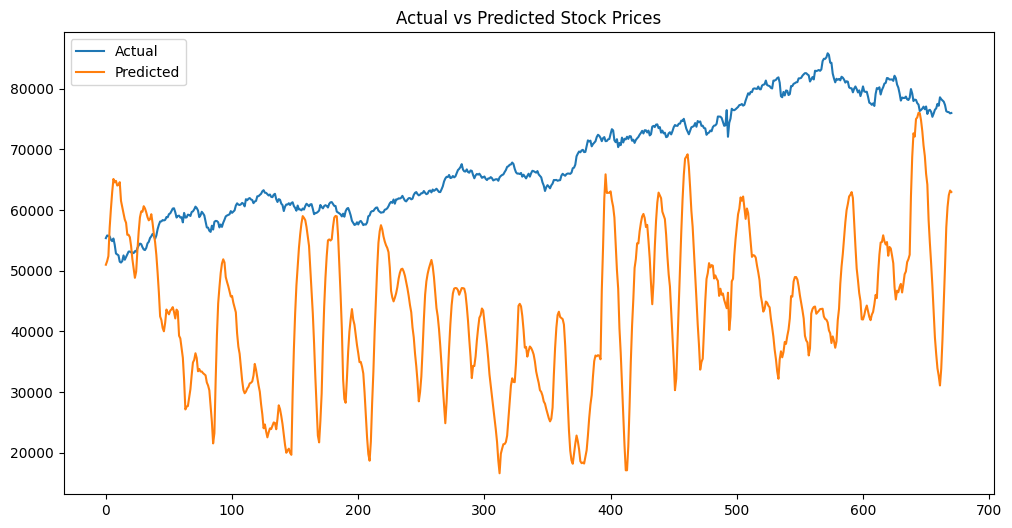

In [61]:
#Plot predicted vs actual
plt.figure(figsize=(12,6))
plt.plot(y_test_inverse, label='Actual')
plt.plot(y_pred_inverse, label='Predicted')
plt.legend()
plt.title("Actual vs Predicted Stock Prices")
plt.show()